![](https://live.staticflickr.com/5009/5277522498_7646c3b586_z.jpg)

# Energy Efficiency

Ths project is based on ... dataset.

# Dictionary (Columns)
- Heating Load (kW) 
- Cooling Load (kW)
- Relative Compactness
- Surface Area
- Wall Area
- Roof Area
- Overall Height
- Orientation
- Glazing Area
- Glazing Area Distribution

# References
[Kaggle dataset](https://www.kaggle.com/datasets/ujjwalchowdhury/energy-efficiency-data-set?rvi=1)

## 1) Importing Libraries and Loading Data

In [2]:
# Libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Reading dataset:
df = pd.read_csv("data\energy_efficiency_data.csv")

In [5]:
# Plotting some records:
df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [7]:
# Informations about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


As we can see above, there are no null values.

## 2) Exploratory Data Analysis

### 2.1) Descriptive Statistics and Distributions

Let's see some descriptive statistics of the variables

In [8]:
df.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [35]:
class Subplots:
    ponto_partida = 0
    def __init__(self, dataframe, n_cols=4) -> None:
        self.dataframe = dataframe
        self.colunas_tamanho = len(dataframe.columns)
        self.n_cols = n_cols
        self.n_rows = (self.colunas_tamanho // 4) + 1
        
        
    def histogram(self):
        fig, ax = plt.subplots(nrows=self.n_rows, ncols=self.n_cols, sharey=False, sharex=False, figsize=(20, 15))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                if Subplots.ponto_partida < self.colunas_tamanho:
                    sns.histplot(df.iloc[:, Subplots.ponto_partida], ax=ax[row, col], kde=True)    
                else:
                    ax[row, col].set_visible(False)
                Subplots.ponto_partida += 1
                
        


#### 2.1.1) Histograms

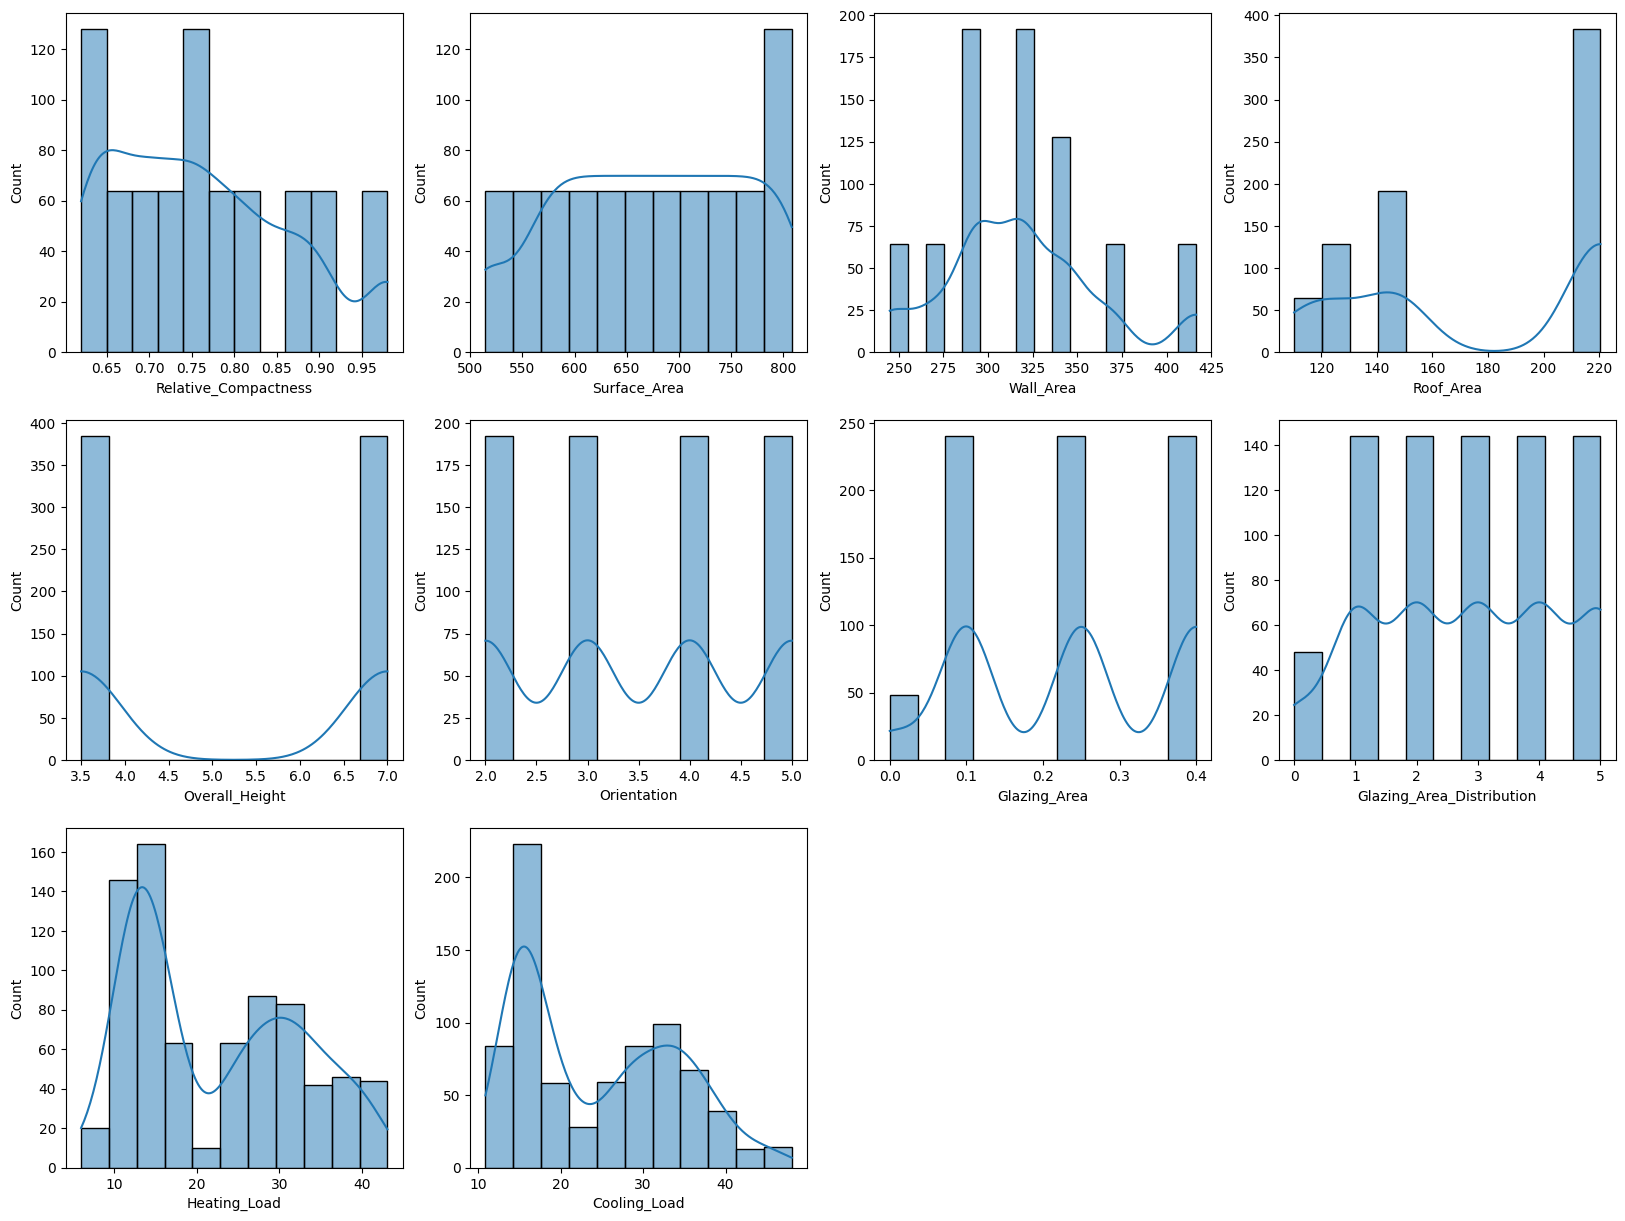

In [36]:
# Histogram plots
subp = Subplots(df)
subp.histogram()

### 2.2) Correlations

### 2.3) Exploring Relations between Variables